In [1]:
# http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *

from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from fastai.utils.collect_env import *

from torch.utils.data import DataLoader, Dataset
from torch import nn

from skimage.util import montage
import pandas as pd

from torch import optim
import re

from functional import seq

from os.path import isfile
from utils import *

In [4]:
show_install()



```text
=== Software === 
python        : 3.7.0
fastai        : 1.0.40.dev0
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 396.54
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 8116MB | GeForce GTX 1080

=== Environment === 
platform      : Linux-4.15.0-44-generic-x86_64-with-debian-buster-sid
distro        : Ubuntu 18.04 Bionic Beaver
conda env     : fastai_updated
python        : /home/dollofcuty/anaconda3/envs/fastai_updated/bin/python
sys.path      : 
/media/dollofcuty/E604249504246B2F/Users/chrun/Documents/Projects/Machine Learning/unstructured data/whale-identification
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python37.zip
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/lib-dynload
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/site-packages
/home/dollofcuty/fastai
/home/do

In [5]:
# import fastai
# from fastprogress import force_console_behavior
# import fastprogress
# fastprogress.fastprogress.NO_BAR = True
# master_bar, progress_bar = force_console_behavior()
# fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

Posing the problem as a classification task is probably not ideal. We are asking our NN to learn to recognize a whale out of 5004 possible candidates based on what it has learned about the whales. That is a tall order.

Instead, here we will try to pose the problem as a verification task. When presented with two images of whale flukes, we will ask the network - are the images of the same whale or of different whales? In particular, we will try to teach our network to learn features that can be useful in determining the similarity between whale images (hence the name of this approach - feature learning).

This seems like a much easier task, at least in theory. Either way, no need to start with a relatively big CNN like resnet50. Let's see what mileage we can get out of resnet18.

In [6]:
# new architecture calls for a new validation set, this time our validation set will consist of all whales that have exactly two images
df = pd.read_csv('data/train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
val_fns = set(df[df.sighting_count == 2].sample(frac=0.2, random_state=21).Image)

In [7]:
len(df), len(val_fns) #only 20%!

(25361, 514)

In [8]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

name = f'siamese-cropped-dropout-lap'

In [9]:
average = [257., 619.]
SZ = np.array(average)//1.5
SZ

array([171., 412.])

In [10]:
BS = 64
NUM_WORKERS = 8
SEED=21

In [11]:
# data_block api creates categories based on classes it sees in the train set and
# our val set contains whales whose ids do not appear in the train set
classes = df.Id.unique()

In [12]:
#xtra = [jitter(magnitude=(-0.001,0.001), is_random=True, p=0.75)]

In [13]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-bbox', cols=['Image']) #[df.Id != 'new_whale']
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-bbox'))
        .transform(get_transforms(max_lighting=0.3, max_rotate=5, max_zoom=1.), #, xtra_tfms=xtra
                   size=SZ, resize_method=ResizeMethod.SQUISH)
)

In [14]:
#todo: try multiple images at once (lap solution maybe)

In [15]:
from lap import lapjv 

In [16]:
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds, score, steps = 10):
        self.ds = ds
        self.x = self.ds.x
        self.y = self.ds.y
        self.whale_ids = ds.y.items
        self.steps =steps
        self.score  = -score
        
        for item in np.unique(ds.y.items):
            candidates = list(np.where(self.whale_ids == item)[0])
            for i in candidates:
                for j in candidates:
                    self.score[i,j] = 10000.0
    
        self.on_epoch_end()
        
    def __len__(self):  return 2 * len(self.ds)
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_image(idx // 2 , 1)
        else: return self.sample_image((idx-1) // 2 ,0)        

    def sample_image(self, idx , tag):
        #set_trace()
        if tag==1:
            first_image_id =  self.match[idx][0] ;  second_image_id = self.match[idx][1]
            if first_image_id == second_image_id:
                return self.sample_image((2*idx -1)//2 , 0)
            else:        
                return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 1)
        else:
            first_image_id =  self.unmatch[idx][0] ;  second_image_id = self.unmatch[idx][1]     
            return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 0)
        
    def on_epoch_end(self):
        if self.steps <= 0: 
            print('no steps left')
            return # Skip this on the last epoch.
        self.steps     -= 1 ; self.match      = [] ;  self.unmatch    = []
        print('steps left: ' , self.steps)
        _,_,x = lapjv(self.score) # Solve the linear assignment problem
        y = np.arange(len(x),dtype=np.int32)

        # Compute a derangement for matching whales
        ct = 0 
        for item in np.unique(self.whale_ids):
            candidates = list(np.where(self.whale_ids == item)[0])
            d = candidates.copy()
            if (len(d)==1): self.match.append((d[0] , d[0]))
            else:
                while True:
                    random.shuffle(candidates)
                    if not np.any(candidates == d): break
                for a ,b in zip(d , candidates): self.match.append((a , b))  ##(self.ds[a][0],self.ds[b][0])

        # Construct unmatched whale pairs from the LAP solution.
        for i,j in zip(x,y):
            if i == j: print(i,j)
            assert i != j
            self.unmatch.append(( i , j) )  #

        self.score[x,y] = 10000.0; self.score[y,x] = 10000.0
        random.shuffle(self.match) ;  random.shuffle(self.unmatch); #print('end of epoch , matching pair',self.match[0]) ; print('end of epoch , unmathcing pair ',self.unmatch[0])
        #print(len(self.match), len(self.ds), len(self.unmatch), len(self.ds))
        #assert len(self.match) == len(train) and len(self.unmatch) == len(train)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

In [17]:
tr_score = np.random.random_sample(size=(len(data.train),len(data.train)))
val_score = np.random.random_sample(size=(len(data.valid),len(data.valid)))

train_dl = DataLoader(
    TwoImDataset(data.train, tr_score, 30),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

valid_dl = DataLoader(
    TwoImDataset(data.valid, val_score,400),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

steps left:  29
steps left:  399


In [18]:
data_bunch = ImageDataBunch(train_dl, valid_dl)

len(data_bunch.train_ds), len(data_bunch.valid_ds)

(30366, 1028)

In [19]:
#import types
#def one_batch(self, ds_type:DatasetType=DatasetType.Train, detach:bool=True, denorm:bool=True, cpu:bool=True)->Collection[Tensor]:
#        "Get one batch from the data loader of `ds_type`. Optionally `detach` and `denorm`."
#        dl = self.dl(ds_type)
#        w = self.num_workers
#        self.num_workers = 0
#        try:     x,y = next(iter(dl))
#        finally: self.num_workers = w
#        if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)
#        norm = getattr(self,'norm',False)
#        if denorm and norm:
#            x = self.denorm(x)
#            if norm.keywords.get('do_y',False): y = self.denorm(y, do_x=True)
#        return x[0],y

In [20]:
#data_bunch.one_batch = types.MethodType(one_batch,data_bunch)

In [21]:
#data_bunch.one_batch()[0].shape

In [22]:
#data_bunch.show_batch(5, DatasetType.Train)

In [23]:
#data_bunch.show_batch(5, DatasetType.Valid)

In [24]:
#paths = np.append(np.append(data.train.x.items, data.valid.x.items), data.test.x.items)

In [25]:
#means = torch.zeros(3)
#stds = torch.zeros(3) 
#
#count =  len(paths)
#count

In [26]:
#for i, fname in enumerate(paths):    
#    img = Image(pil2tensor(PIL.Image.open(fname).convert('RGB'), np.float32).div_(255)).data
#    means += torch.Tensor([torch.mean(img[0]), torch.mean(img[1]), torch.mean(img[2])])
#    stds += torch.Tensor([torch.std(img[0]), torch.std(img[1]), torch.std(img[2])])
#    if i % 10000 == 0: print(i)
#
#mean = means/count
#std = stds/count
#mean, std

In [27]:
#stats = ([0.4670, 0.4965, 0.5322], [0.2385, 0.2414, 0.2466])
stats = ([0.4556, 0.4866, 0.5243], [0.2378, 0.2417, 0.2478])

In [28]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [29]:
data_bunch.add_tfm(normalize_batch)

In [30]:
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    def __init__(self, learn:Learner, monitor:str='trn_loss', mode:str='auto'):
        super().__init__(learn)
        self.monitor,self.mode = monitor,mode
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__class__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]

    def on_train_begin(self, **kwargs:Any)->None:
        "Initializes the best value."
        self.best = float('inf') if self.operator == np.less else -float('inf')

    def get_monitor_value(self):
        "Pick the monitored value."
        if self.monitor=='trn_loss' and len(self.learn.recorder.losses) == 0: return None
        elif len(self.learn.recorder.val_losses) == 0: return None
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=self.learn.recorder.metrics[-1:][0][i]
        if values.get(self.monitor) is None:
            warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')
        return values.get(self.monitor)

In [31]:
class SaveModel(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and (self.learn.path/f'{self.learn.model_dir}/{self.name}.pth').is_file():
            self.learn.load(f'{self.name}')

In [32]:
@dataclass
class UpdateScoreMatrix(LearnerCallback):
    def __init__(self, learn:Learner):
        super().__init__(learn)
        
    def on_epoch_end(self, **kwargs):
        learn.data.train_dl.dataset.on_epoch_end()

In [33]:
from functional import seq

class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet34):
        super().__init__()
        self.cnn = create_body(arch)
        #self.cnn[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        actn = nn.ReLU(inplace=True)
        
        mid = 32
        self.conv1 =  nn.Sequential(*[nn.Conv2d(1,mid, kernel_size = (  1, 4), padding = 0, stride=1), actn])
        self.conv2 =  nn.Sequential(*[nn.Conv2d(1,  1, kernel_size = (mid, 1), padding = 0, stride=1), Flatten()])
        
        self.bdl  =  nn.Sequential(*[nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(in_features=512, out_features=64, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                     nn.Dropout(p=0.2),
                                     nn.Linear(in_features=64, out_features=1, bias=True)])

    def forward(self, im_A, im_B):
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)#.map(self.pooling)
        #print(x1.shape, x2.shape)
        feat = self.calculate_features(x1, x2)
        #print(feat.shape)
        feat = feat.view(-1, 1, num_features_model(self.cnn), 4)
        con1 = self.conv1(feat)
        #print(con1.shape)
        con1 = con1.view(-1, 1, 32, num_features_model(self.cnn))
        con2 = self.conv2(con1)
        #print(con2.shape)
        con2 = con2.view(-1, num_features_model(self.cnn))
        out = self.bdl(con2)
        #out = self.fc(con2)
        #print(out)
        return out

    def calculate_features(self, x1, x2):
        mu = x1 * x2
        ad = x1 + x2
        mi = torch.abs(x1-x2)
        sq = mi**2
        x = torch.cat([mu, ad, mi, sq], dim=1)
        return x

    def process_features(self, x): 
        y = x.reshape(*x.shape[:2], -1)
        return x.reshape(*x.shape[:2], -1).max(-1)[0]

In [34]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), callback_fns=[ShowGraph, UpdateScoreMatrix],
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [35]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.conv1])

In [36]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [37]:
learn.freeze_to(-1)

steps left:  28
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


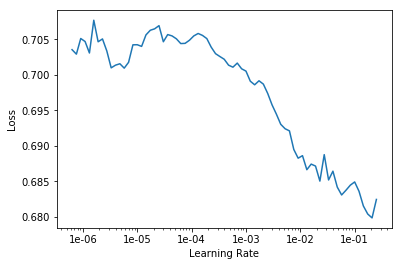

In [38]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,
1,0.389059,0.246623,0.907588
2,0.324193,0.242063,0.905642
3,0.266699,0.176408,0.945525
4,0.222275,0.155875,0.950389


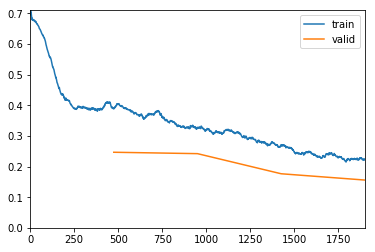

steps left:  27
steps left:  26
steps left:  25
steps left:  24


In [39]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,
1,0.362407,0.343842,0.875486
2,0.310285,0.305928,0.899805
3,0.227446,0.129866,0.957198
4,0.189101,0.111072,0.965953


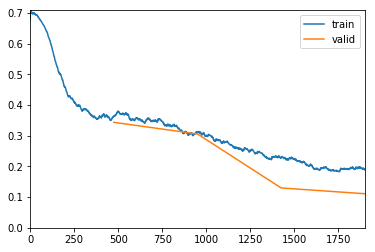

steps left:  27
steps left:  26
steps left:  25
steps left:  24


In [38]:
learn.fit_one_cycle(4, 1e-2)

In [40]:
learn.save(f'{name}-stage-1')

In [41]:
learn.unfreeze()

steps left:  23
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


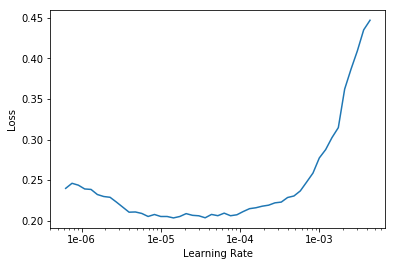

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.callback_fns.append(partial(SaveModel, every='improvement', name=f'{name}-stage-2'))

In [44]:
max_lr = 3e-4
lrs = slice(max_lr/9,max_lr)
learn.lr_range(lrs)

array([3.333333e-05, 1.000000e-04, 3.000000e-04])

epoch,train_loss,valid_loss,
1,0.220843,0.156034,0.954280
2,0.199810,0.137981,0.953307
3,0.216064,0.139817,0.949416
4,0.194960,0.120412,0.961089
5,0.194077,0.119013,0.960117
6,0.177609,0.134359,0.955253
7,0.185944,0.124027,0.955253
8,0.170115,0.105219,0.971790
9,0.157809,0.139575,0.958171
10,0.149381,0.095850,0.974708


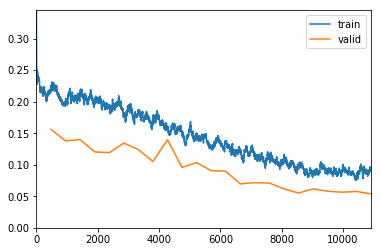

steps left:  22
steps left:  21
steps left:  20
steps left:  19
steps left:  18
steps left:  17
steps left:  16
steps left:  15
steps left:  14
steps left:  13
steps left:  12
steps left:  11
steps left:  10
steps left:  9
steps left:  8
steps left:  7
steps left:  6
steps left:  5
steps left:  4
steps left:  3
steps left:  2
steps left:  1
steps left:  0


In [45]:
learn.fit_one_cycle(23, lrs) #4e-4, 24e, slice(max_lr/9,max_lr), div_factor=25

In [37]:
learn.load(f'{name}-stage-2');

In [38]:
new_data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-bbox', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-bbox'))
        .transform(get_transforms(max_lighting=0.3, max_rotate=5, max_zoom=1.), #, xtra_tfms=xtra
                   size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(stats)
)

In [39]:
def score_generation(learn , new_data):
    features = []
    train_class_idxs = []
    learn.model.eval()
    for ims, t in new_data.train_dl:
        features.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
        train_class_idxs.append(t)

    train_class_idxs = torch.cat(train_class_idxs)
    features = torch.cat(features)
    print(len(features))

    sims = []
    for feat in features:
        feat = learn.model.calculate_features(features, feat.unsqueeze(0).repeat(15168, 1))
        feat = feat.view(-1, 1, num_features_model(learn.model.cnn), 4)
        con1 = learn.model.conv1(feat.cuda())
        con1 = con1.view(-1, 1, 32, num_features_model(learn.model.cnn))
        con2 = learn.model.conv2(con1)
        con2 = con2.view(-1, num_features_model(learn.model.cnn))
        predicted_similarity = learn.model.bdl(con2).sigmoid_()
        sims.append(predicted_similarity.squeeze().detach().cpu().numpy())

    sims_np = np.asarray(sims)
    return sims_np

In [40]:
%%time
ampl = 100.0
sims_np = score_generation(learn, new_data)

15168
CPU times: user 40min 35s, sys: 22min 7s, total: 1h 2min 43s
Wall time: 1h 3min 34s


In [ ]:
sims_np.shape, sims_np[-1]

In [40]:
score = sims_np.copy() #+ np.array(ampl*np.random.random_sample(size = (15168, 15168)))

In [43]:
score.shape

(15168, 15168)

In [45]:
data.train

LabelList
y: CategoryList (15183 items)
[Category w_f48451c, Category w_c3d896a, Category w_20df2c5, Category w_dd88965, Category w_64404ac]...
Path: data/train-bbox
x: ImageItemList (15183 items)
[Image (3, 257, 619), Image (3, 160, 744), Image (3, 442, 987), Image (3, 448, 976), Image (3, 313, 1030)]...
Path: data/train-bbox

In [44]:
train_dl = DataLoader(
    TwoImDataset(data.train, score, 38),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

AttributeError: train

## Size 257x619

In [ ]:
SZ_BIG = np.array(average) * 1.2
SZ_BIG

In [ ]:
#SZ_BIG = average
BS = 16
NUM_WORKERS = 8

In [ ]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-bbox', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-bbox'))
        .transform(get_transforms(max_lighting=0.3, max_rotate=5, max_zoom=1.), #, xtra_tfms=xtra
                   size=SZ_BIG, resize_method=ResizeMethod.SQUISH)
)

In [ ]:
#data.train.x.convert_mode = 'L'
#data.valid.x.convert_mode = 'L'
#data.test.x.convert_mode = 'L'

In [ ]:
val_score = np.random.random_sample(size=(len(data.valid),len(data.valid)))

train_dl = DataLoader(
    TwoImDataset(data.train, score, 38),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

valid_dl = DataLoader(
    TwoImDataset(data.valid, val_score,400),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

In [ ]:
data_bunch = ImageDataBunch(train_dl, valid_dl)

data_bunch.add_tfm(normalize_batch)

In [ ]:
len(data_bunch.train_ds), len(data_bunch.valid_ds)

In [ ]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), callback_fns=[ShowGraph, UpdateScoreMatrix],
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [ ]:
#learn.data.train_ds.ds.x.convert_mode = 'L'
#learn.data.valid_ds.ds.x.convert_mode = 'L'

In [ ]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.conv1])

In [ ]:
learn.layer_groups

In [ ]:
learn.load(f'{name}-stage-2');

In [ ]:
learn.freeze_to(-1)

In [ ]:
learn.lr_find(num_it=500)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 4e-3)

epoch,train_loss,valid_loss,
1,0.173062,0.107688,0.962062
2,0.189662,0.196390,0.939689
3,0.158547,0.103111,0.967899
4,0.141234,0.109381,0.962062


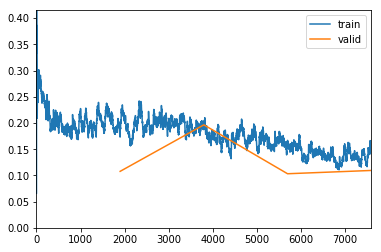

In [56]:
learn.fit_one_cycle(4, 4e-3)

In [ ]:
learn.save(f'{name}-big-stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.callback_fns.append(partial(SaveModel, every='epoch', name=f'{name}-big-stage-2'))

In [ ]:
max_lr = 2e-4
lrs = slice(max_lr/9,max_lr)
learn.lr_range(lrs)

In [ ]:
learn.fit_one_cycle(32, lrs, div_factor=40) #2e-4, slice(max_lr/9,max_lr), div_factor=50

## validate 

In [45]:
#name='res34-siamese-differenthead'

In [132]:
learn.load(f'{name}-big-stage-2_28');

In [133]:
learn.model.eval();

In [134]:
new_whale_fns = set(df[df.Id == 'new_whale'].sample(frac=1).Image.iloc[:1000])
len(new_whale_fns)

1000

In [135]:
SZ_BIG = np.array(average) * 1.2
SZ_BIG

array([308.4, 742.8])

In [136]:
BS = 16
NUM_WORKERS = 8

In [137]:
data = (
    ImageItemList
        .from_df(df, f'data/train-bbox', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns.union(new_whale_fns)) #.union(new_whale_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-bbox'))
        .transform(get_transforms(max_lighting=0.3, max_rotate=5, max_zoom=1.), #, xtra_tfms=xtra
                   size=SZ_BIG, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(stats)
)

In [138]:
#x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)#.map(self.pooling)
#feat = self.calculate_features(x1, x2)
#feat = feat.view(-1, 1, num_features_model(self.cnn), 4)
#con1 = self.conv1(feat)
#con1 = con1.view(-1, 1, 32, num_features_model(self.cnn))
#con2 = self.conv2(con1)
#con2 = con2.view(-1, num_features_model(self.cnn))
#out = self.fc(con2)

In [180]:
%%time
targs = []
feats = []
for ims, ts in data.valid_dl:
    #print(ims.shape)
    feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    targs.append(ts)

CPU times: user 5.18 s, sys: 2.82 s, total: 8 s
Wall time: 8.58 s


In [181]:
feats = torch.cat(feats)

In [182]:
targs = torch.cat(targs)

In [183]:
feats.shape, targs.shape

(torch.Size([1257, 512]), torch.Size([1257]))

In [186]:
%%time
sims = []
for feat in feats:
    x1 = feats
    x2 = feat.unsqueeze(0).repeat(1257 ,1)
    feat = learn.model.calculate_features(x1 , x2)
    feat = feat.view(-1, 1, num_features_model(learn.model.cnn), 4)
    con1 = learn.model.conv1(feat.cuda())
    con1 = con1.view(-1, 1, 32, num_features_model(learn.model.cnn))
    con2 = learn.model.conv2(con1)
    con2 = con2.view(-1, num_features_model(learn.model.cnn))
    predicted_similarity = learn.model.bdl(con2).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 34.8 s, sys: 1.38 s, total: 36.2 s
Wall time: 36.2 s


In [66]:
new_whale_idx = np.where(classes == 'new_whale')[0][0]

In [60]:
%%time
top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if len(top_5) == 5: break
        if j == new_whale_idx or j == i: continue
        predicted_class = data.valid_ds.y.items[j]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 1.29 s, sys: 360 µs, total: 1.29 s
Wall time: 1.34 s


In [61]:
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.6812138188608777

In [65]:
%%time
thresh_dict = {}

for thresh in np.linspace(0.96, 0.98, 11):
    top_5s = []
    for i, sim in enumerate(sims):
        idxs = sim.argsort(descending=True)
        probs = sim[idxs]
        top_5 = []
        for j, p in zip(idxs, probs):
            if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
            if len(top_5) == 5: break
            if j == new_whale_idx or j == i: continue
            predicted_class = data.valid_ds.y.items[j]
            if predicted_class not in top_5: top_5.append(predicted_class)
        top_5s.append(top_5)
    thresh_dict[thresh] = np.round(mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5),decimals=6)
    print(thresh, np.round(mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5),decimals=6))

0.96 0.727292
0.962 0.727059
0.964 0.726662
0.966 0.726797
0.968 0.726886
0.97 0.727633
0.972 0.727376
0.974 0.72606
0.976 0.72267
0.978 0.719729
0.98 0.717176
CPU times: user 16.4 s, sys: 4.73 ms, total: 16.4 s
Wall time: 16.4 s


In [66]:
thresh = max(thresh_dict, key=thresh_dict.get)
thresh

0.97

In [67]:
#best thresh: 0.999

In [68]:
%%time

top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
        if len(top_5) == 5: break
        if j == new_whale_idx or j == i: continue
        predicted_class = data.valid_ds.y.items[j]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 1.32 s, sys: 407 µs, total: 1.32 s
Wall time: 1.33 s


In [69]:
# without predicting new_whale
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.7276330532212886

There are many reasons why the best threshold here might not carry over to what would make sense on the test set. It is some indication though of how our model is doing and a useful data point.

## Predict

In [40]:
len(data.test_ds)

AttributeError: test_ds

In [71]:
data = (
    ImageItemList
        .from_df(df, f'data/train-bbox', cols=['Image'])
        .no_split()
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-bbox'))
        .transform(get_transforms(max_lighting=0.3, max_rotate=5, max_zoom=1.), #, xtra_tfms=xtra
                   size=SZ_BIG, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(stats)
)

In [72]:
%%time
test_feats = []
learn.model.eval()
for ims, _ in data.test_dl:
    test_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())

CPU times: user 34 s, sys: 17.5 s, total: 51.5 s
Wall time: 52.6 s


In [73]:
%%time
train_feats = []
train_class_idxs = []
learn.model.eval()
for ims, t in data.train_dl:
    train_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    
    train_class_idxs.append(t)

CPU times: user 2min 3s, sys: 56.6 s, total: 3min
Wall time: 3min 2s


In [74]:
train_class_idxs = torch.cat(train_class_idxs)
train_feats = torch.cat(train_feats)

In [75]:
test_feats = torch.cat(test_feats)

In [76]:
train_feats.shape, test_feats.shape

(torch.Size([25360, 512]), torch.Size([7960, 512]))

In [77]:
%%time
sims = []
for feat in test_feats:
    x1 = train_feats
    x2 = feat.unsqueeze(0).repeat(25360, 1)
    feat = learn.model.calculate_features(x1 , x2)
    feat = feat.view(-1, 1, num_features_model(learn.model.cnn), 4)
    con1 = learn.model.conv1(feat.cuda())
    con1 = con1.view(-1, 1, 32, num_features_model(learn.model.cnn))
    con2 = learn.model.conv2(con1)
    con2 = con2.view(-1, num_features_model(learn.model.cnn))
    predicted_similarity =  learn.model.bdl(con2).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 28min 42s, sys: 18min 54s, total: 47min 36s
Wall time: 47min 41s


In [78]:
#todo: verify thresh

In [79]:
thresh

0.97

In [98]:
thresh = 0.99

In [99]:
%%time

top_5s = []
for sim in sims:
    idxs = sim.argsort(descending = True)
    probs = sim[idxs]
    top_5 = []
    for  i , p in zip(idxs , probs):
        if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5:
            top_5.append(new_whale_idx)
        if len(top_5) == 5: break
        #if i == new_whale_idx: continue
        predicted_class = train_class_idxs[i]
        #print(predicted_class)
        if predicted_class == new_whale_idx: continue
        if predicted_class not in top_5:
            top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 23.5 s, sys: 887 ms, total: 24.4 s
Wall time: 24.4 s


In [100]:
top_5_classes = []
for top_5 in top_5s:
    top_5_classes.append(' '.join([classes[t] for t in top_5]))

In [101]:
top_5_classes[:5]

['new_whale w_dec7ffd w_00f340d w_0369a5c w_05b4b0c',
 'w_4132bb8 new_whale w_6cec90c w_715ceba w_636aa5b',
 'w_37e61c2 new_whale w_94c3bf0 w_0e7aae1 w_31b5dd8',
 'w_c99807e w_a335fc2 new_whale w_e21b629 w_59052ad',
 'w_9e18daa w_2a946f2 w_367832c w_b524f96 w_640a24a']

In [102]:
sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
sub['Id'] = top_5_classes
sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [103]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,00028a005.jpg,new_whale w_dec7ffd w_00f340d w_0369a5c w_05b4b0c
1,000dcf7d8.jpg,w_4132bb8 new_whale w_6cec90c w_715ceba w_636aa5b
2,000e7c7df.jpg,w_37e61c2 new_whale w_94c3bf0 w_0e7aae1 w_31b5dd8
3,0019c34f4.jpg,w_c99807e w_a335fc2 new_whale w_e21b629 w_59052ad
4,001a4d292.jpg,w_9e18daa w_2a946f2 w_367832c w_b524f96 w_640a24a


In [104]:
pd.read_csv(f'subs/{name}.csv.gz').Id.str.split().apply(
    lambda x: x[0] == 'new_whale').mean()

0.32537688442211055

In [105]:
pd.read_csv(f'data/train.csv').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.3810575292772367

In [106]:
name

'siamese-cropped-dropout'

In [ ]:
#TODO: try only 10% of val set and training with hard examples 

In [ ]:
#fastai head after conv 0.1, 0.2 dropout epoch: 24
#thresh 0.99
#0.687 local lb

#thresh 0.995
#0.699 local lb

#thresh 0.996
#0.695 local lb

#fastai head after conv 0.1, 0.2 dropout epoch: 28
#thresh 0.995
#0.685 local lb

#thresh 0.994
#0.697 local lb